# Phase 3 - Retention Prediction
In the two prevoius phases of this project, I explored the data and prepared it for modeling. In this phase, I create machine learning models to predict retention. I will create Naive Bayes, Decision Tree, and XGBoost models. Evaluation data is used to compare the models' performance.

## Import Required Packages

In [3]:
# Standard Python packages
from math import sqrt
import pickle

# Data packages
import pandas as pd
import numpy as np

# Visualization Packages
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning / Classification packages
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,\
roc_auc_score, roc_curve, auc,\
confusion_matrix, classification_report,\
ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from xgboost import XGBClassifier
from xgboost import plot_importance


In [4]:
# Load pickled data
with open('Data//prepared data.pickle', 'rb') as file:
    df = pickle.load(file)
df.shape

(413953, 45)

In [5]:
df['is_churned'] = 1 - df['is_retained']
df.head()

,is_retained,cnt_courses_in_specialization,is_professional_certificate,is_gateway_certificate,learner_cnt_other_courses_active,learner_cnt_other_courses_paid_active,learner_cnt_other_courses_items_completed,learner_cnt_other_courses_paid_items_completed,learner_cnt_other_transactions_past,learner_other_revenue,...,Eastern Europe,India,Middle East,Non-Brazil Latin America,Northern Europe,Russia and neighbors,Southeast Asia,Southern Europe,United States,is_churned
0,1.0,8.0,True,True,8.0,0.0,88.0,0.0,0.0,0.00,...,False,False,False,False,True,False,False,False,False,0.0
1,0.0,6.0,True,False,52.0,2.0,209.0,75.0,1.0,49.41,...,False,False,False,False,True,False,False,False,False,1.0
2,0.0,6.0,True,True,5.0,0.0,5.0,0.0,0.0,0.00,...,False,False,False,False,False,False,False,False,False,1.0
3,1.0,5.0,True,True,0.0,0.0,0.0,0.0,0.0,0.00,...,False,False,False,False,False,False,False,False,True,0.0
4,0.0,8.0,True,True,0.0,0.0,0.0,0.0,0.0,0.00,...,False,True,False,False,False,False,False,False,False,1.0


## Handle Outliers

In [6]:
# Utility function to find and cap the outliers

def cap_outlier(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    IQR = q3 - q1
    lower_limit = q1 - 1.5 * IQR
    upper_limit = q3 + 1.5 * IQR

    column = np.where(df[col] > upper_limit, upper_limit, 
                       np.where(df[col] < lower_limit, lower_limit, df[col]))
    return column


In [7]:
df1 = df.copy()
for col in df1.columns:
    if df1[col].dtype in ["int64","float64"]:
        df1[col] = cap_outlier(df1, col)

df1.describe()

,is_retained,cnt_courses_in_specialization,learner_cnt_other_courses_active,learner_cnt_other_courses_paid_active,learner_cnt_other_courses_items_completed,learner_cnt_other_courses_paid_items_completed,learner_cnt_other_transactions_past,learner_other_revenue,subscription_period_order,days_since_last_payment,...,cnt_enrollments_active_during_payment_period,cnt_items_completed_during_payment_period,cnt_graded_items_completed_during_payment_period,sum_hours_learning_before_payment_period,sum_hours_learning_during_payment_period,cnt_days_active_before_payment_period,cnt_days_active_during_payment_period,cnt_days_since_last_activity,Popularity,is_churned
count,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,...,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000,413953.000000
mean,0.543663,5.919438,2.718632,0.555917,56.487657,8.042605,0.637449,30.626475,2.248905,12.398519,...,0.627710,12.179784,1.053938,12.415559,2.159619,10.200452,2.298471,21.194913,1.317979,0.456337
std,0.498090,1.736631,3.630505,0.932907,83.313962,13.583526,0.995666,48.620278,1.657074,8.655959,...,0.769763,18.159668,1.737287,14.487067,3.173857,10.979661,3.169519,26.136959,0.551951,0.498090
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.162325,0.000000
25%,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,...,0.000000,0.000000,0.000000,1.150000,0.000000,2.000000,0.000000,1.000000,0.850538,0.000000
50%,1.000000,6.000000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000,2.000000,12.000000,...,0.000000,0.000000,0.000000,6.183333,0.000000,6.000000,1.000000,9.000000,0.957605,0.000000
75%,1.000000,7.000000,4.000000,1.000000,90.000000,13.000000,1.000000,49.000000,3.000000,20.000000,...,1.000000,20.000000,2.000000,18.633333,3.533333,15.000000,4.000000,32.000000,1.995327,1.000000
max,1.000000,10.000000,10.000000,2.500000,225.000000,32.500000,2.500000,122.500000,6.000000,31.000000,...,2.500000,50.000000,5.000000,44.858333,8.833333,34.500000,10.000000,78.500000,1.995327,1.000000


## Sample Data

My data is very large, in my first attempt to fit a randomforest model, it was too slow to get any result on my laptop. So I select a subset of the data to train my models.

In [8]:
n = 50000
df1 = df.sample(n, ignore_index=True)
df1.shape

(50000, 46)

## Choose Evaluation Metric
Before modeling, we must decide on an evaluation metric. This will depend on the class balance of the target variable and the use case of the model.

First, let's examine the class balance of the target variable.

In [9]:
# Get class balance of 'is_retained' col for the entire data
df['is_churned'].value_counts(normalize=True)


is_churned
0.0    0.543663
1.0    0.456337
Name: proportion, dtype: float64

In [10]:
# Get class balance of 'is_retained' col for the subset
df1['is_churned'].value_counts(normalize=True)

is_churned
0.0    0.5464
1.0    0.4536
Name: proportion, dtype: float64

Our data is balanced which may tempt us to use precision as a good metric. But more than precision, it is more important for us to have a good score in identifying the learners who are very likely to churn. This means that I user recall as a main metric to evaluate my models.

## Split the Data

In [11]:
X = df1.drop(columns=['is_retained', 'is_churned'])
y = df1['is_churned']

# Split into test and 'other'
X_, X_test, y_, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_, y_, stratify=y_, test_size=0.25, random_state=42)
                                                  

## Utility Functions for Reporting Results

In [12]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [13]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

## Build Naive Bayes Model

In [14]:
# Fit the model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_preds = gnb.predict(X_test)

In [15]:
print('Accuracy:', '%.3f' % accuracy_score(y_test, y_preds))
print('Precision:', '%.3f' % precision_score(y_test, y_preds))
print('Recall:', '%.3f' % recall_score(y_test, y_preds))
print('F1 Score:', '%.3f' % f1_score(y_test, y_preds))

Accuracy: 0.604
Precision: 0.616
Recall: 0.339
F1 Score: 0.437


In [23]:
results = pd.DataFrame()
gnb_results = get_test_scores('gnb', y_preds, y_test)
results = pd.concat([results, gnb_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,gnb,0.616032,0.338845,0.437207,0.6043


## Build Random forest Model

In [17]:
rf = RandomForestClassifier(random_state=42)

param_grid = {'max_depth': [4, 6, 8],
             'max_features': [None],
             'max_samples': [None],
             'min_samples_leaf': [3, 5],
             'min_samples_split': [2, 4],
             'n_estimators': [100],
             }

scoring = ['accuracy', 'precision', 'recall', 'f1']

rf_cv = GridSearchCV(rf, param_grid, scoring=scoring, cv=4, refit='recall')


In [18]:
%%time
rf_cv.fit(X_train, y_train)


C:\Users\Adak\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


CPU times: total: 8min 2s
Wall time: 8min 10s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [4, 6, 8], 'max_features': [None],
                         'max_samples': [None], 'min_samples_leaf': [3, 5],
                         'min_samples_split': [2, 4], 'n_estimators': [100]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [19]:
rf_cv.best_score_

np.float64(0.5964873603762493)

In [20]:
rf_cv.best_params_

{'max_depth': 6,
 'max_features': None,
 'max_samples': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 100}

In [24]:
# results = pd.DataFrame()
rf_results = make_results('RF cv', rf_cv, 'recall')
results = pd.concat([results, rf_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,gnb,0.616032,0.338845,0.437207,0.6043
0,RF cv,0.648732,0.596487,0.621483,0.6705


## Build XGBoost Model

In [25]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

param_grid = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

scoring = ['accuracy', 'precision', 'recall', 'f1']

xgb_cv = GridSearchCV(xgb, param_grid, scoring=scoring, cv=4, refit='recall')

In [26]:
%%time
xgb_cv.fit(X_train, y_train)


CPU times: total: 6min 4s
Wall time: 1min 58s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [27]:
# Examine best score
xgb_cv.best_score_

np.float64(0.6003086419753088)

In [28]:
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,gnb,0.616032,0.338845,0.437207,0.604300
0,RF cv,0.648732,0.596487,0.621483,0.670500
0,XGB cv,0.655606,0.600309,0.626726,0.675667


XGBoost performed better that random forest and bayasian model in all metrics.

## Model Selection

In [29]:
rf_val_preds = rf_cv.best_estimator_.predict(X_val)


In [30]:
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,gnb,0.616032,0.338845,0.437207,0.604300
0,RF cv,0.648732,0.596487,0.621483,0.670500
0,XGB cv,0.655606,0.600309,0.626726,0.675667
0,RF val,0.660142,0.594797,0.625768,0.677300


In [31]:
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,gnb,0.616032,0.338845,0.437207,0.604300
0,RF cv,0.648732,0.596487,0.621483,0.670500
0,XGB cv,0.655606,0.600309,0.626726,0.675667
0,RF val,0.660142,0.594797,0.625768,0.677300
0,XGB val,0.670617,0.611332,0.639603,0.687500


## Prediction Using the Champion Model on Test Data

In [32]:
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,gnb,0.616032,0.338845,0.437207,0.604300
0,RF cv,0.648732,0.596487,0.621483,0.670500
0,XGB cv,0.655606,0.600309,0.626726,0.675667
0,RF val,0.660142,0.594797,0.625768,0.677300
0,XGB val,0.670617,0.611332,0.639603,0.687500
0,XGB test,0.666588,0.620591,0.642767,0.687100


## Evaluation of Champion Model

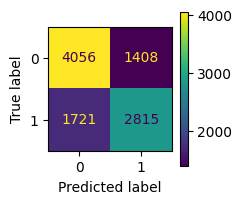

In [33]:
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                             # display_labels=['churned', 'retained'])
fig, ax = plt.subplots(figsize=(2,2))
disp.plot(ax=ax);


### Feature Importance

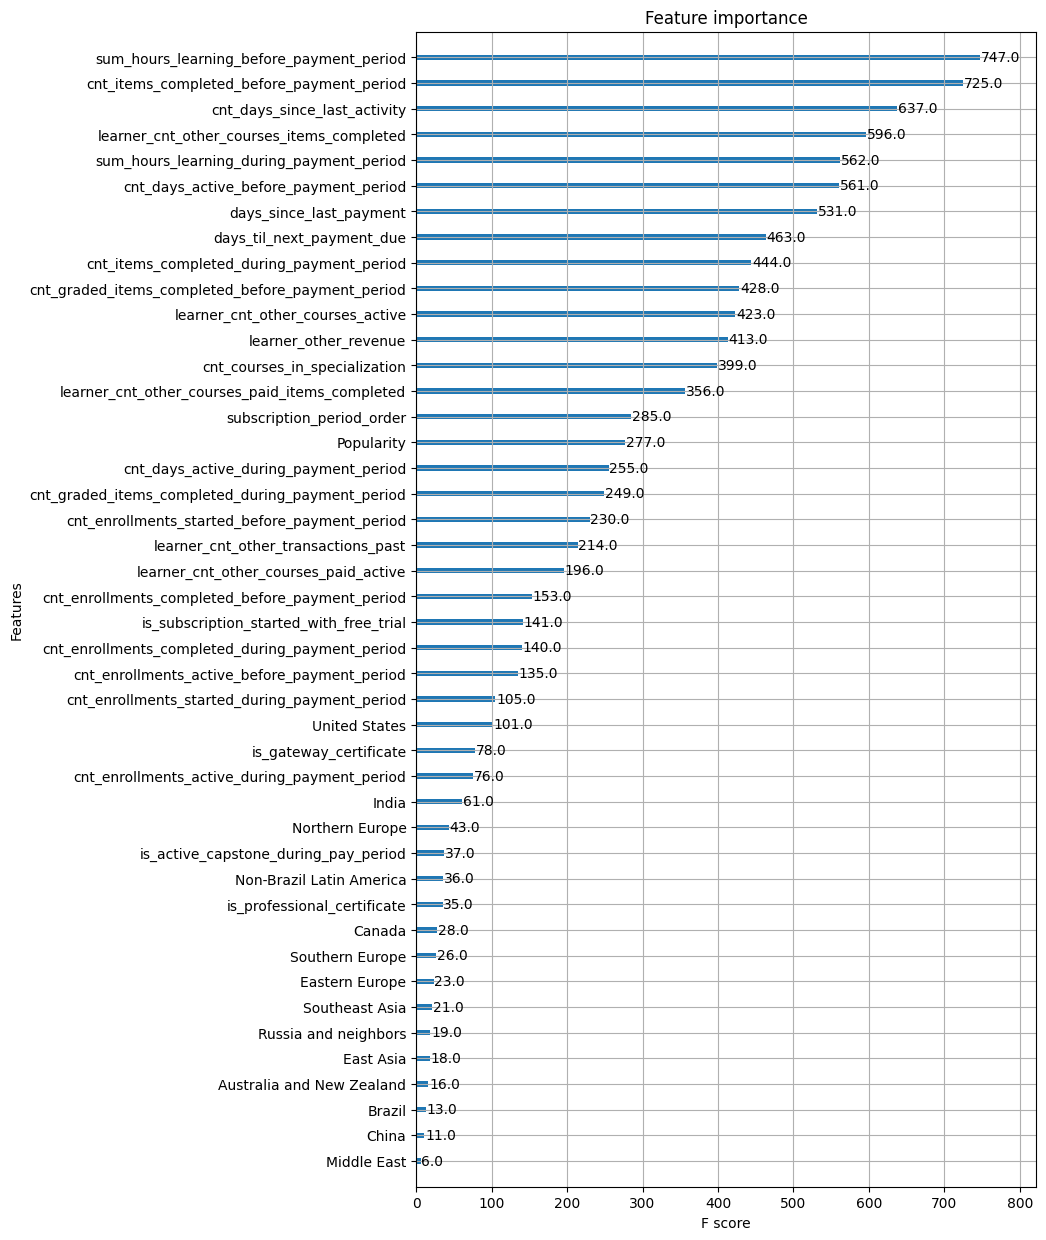

In [34]:
fig, ax = plt.subplots(figsize=(8,15))
plot_importance(xgb_cv.best_estimator_, ax=ax);

## Identify an optimal decision threshold

The default decision threshold for most implementations of classification algorithms&mdash;including scikit-learn's&mdash;is 0.5. This means that, in the case of all models we implemented in this notebook, if they predicted that a given user had a 50% probability or greater of churning, then that user was assigned a predicted value of `1`&mdash;the user was predicted to churn.

This threshold might not be ideal for all applications. A precision-recall curve can help to visualize the trade-off between our model's precision and recall.

Here's the precision-recall curve for the XGBoost champion model on the test data.

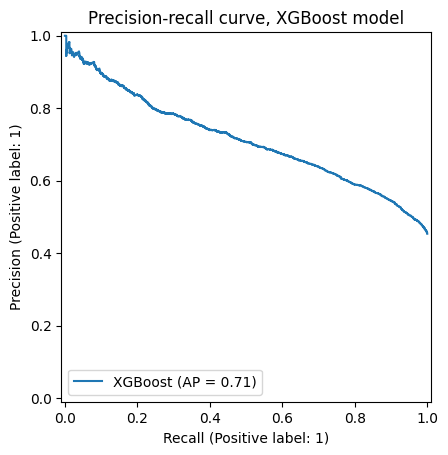

In [35]:
# Plot precision-recall curve
display = PrecisionRecallDisplay.from_estimator(
    xgb_cv.best_estimator_, X_test, y_test, name='XGBoost'
    )
plt.title('Precision-recall curve, XGBoost model');

In [36]:
predicted_probabilities = xgb_cv.best_estimator_.predict_proba(X_test)
predicted_probabilities

array([[0.7794311 , 0.22056891],
       [0.35933596, 0.64066404],
       [0.35884458, 0.6411554 ],
       ...,
       [0.7718713 , 0.22812866],
       [0.2628067 , 0.7371933 ],
       [0.44624466, 0.55375534]], dtype=float32)

In [37]:
probs = [x[1] for x in predicted_probabilities]

new_preds = np.array([1 if x >= 0.3 else 0 for x in probs])
new_preds

array([0, 1, 1, ..., 0, 1, 1])

In [38]:
get_test_scores('XGB, threshold = 0.3', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.3",0.560402,0.872354,0.682418,0.6317


In [39]:
def threshold_finder(y_test_data, probabilities, desired_recall):
    '''
    Find the decision threshold that most closely yields a desired recall score.

    Inputs:
        y_test_data: Array of true y values
        probabilities: The results of the `predict_proba()` model method
        desired_recall: The recall that you want the model to have

    Outputs:
        threshold: The decision threshold that most closely yields the desired recall
        recall: The exact recall score associated with `threshold`
    '''
    probs = [x[1] for x in probabilities]  
    thresholds = np.arange(0, 1, 0.001)

    scores = []
    for threshold in thresholds:
        preds = np.array([1 if x >= threshold else 0 for x in probs])
        recall = recall_score(y_test_data, preds)
        scores.append((threshold, recall))

    distances = []
    for idx, score in enumerate(scores):
        distance = abs(score[1] - desired_recall)
        distances.append((idx, distance))

    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=False)
    best = sorted_distances[0]
    best_idx = best[0]
    threshold, recall = scores[best_idx]

    return threshold, recall


In [40]:
probabilities = xgb_cv.best_estimator_.predict_proba(X_test)
threshold_finder(y_test, probabilities, 0.95)

(np.float64(0.192), np.float64(0.9497354497354498))

In [41]:
new_preds = np.array([1 if x >= 0.196 else 0 for x in probs])
get_test_scores('XGB, threshold = 0.196', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.196",0.507021,0.94731,0.660518,0.5583


So, with altering the threshold, we improved recall to 95 percent which is vary good. Our champion model can predict 90% of churns, although it's accuracy if only 56%. In practice I have consult with stakeholders to set the optimum value for our recall before finding the threshold. 

## Conclusion
The model's performance is good and gives me a lot of clues for further investigation.
- The feature importance chart says that I can remove the `learner_region` altogether.
- I can define a new feature that represents **engagement**, the more engaged a learner is to their current and previous courses, the higher the chances of retention.
- I can create a measure that represents if the learner is near finishing this specialization and leaving the platform.<br>
This project continues in another phase to use deep learning for better prediction.